Precipitación acumulada (24h) 

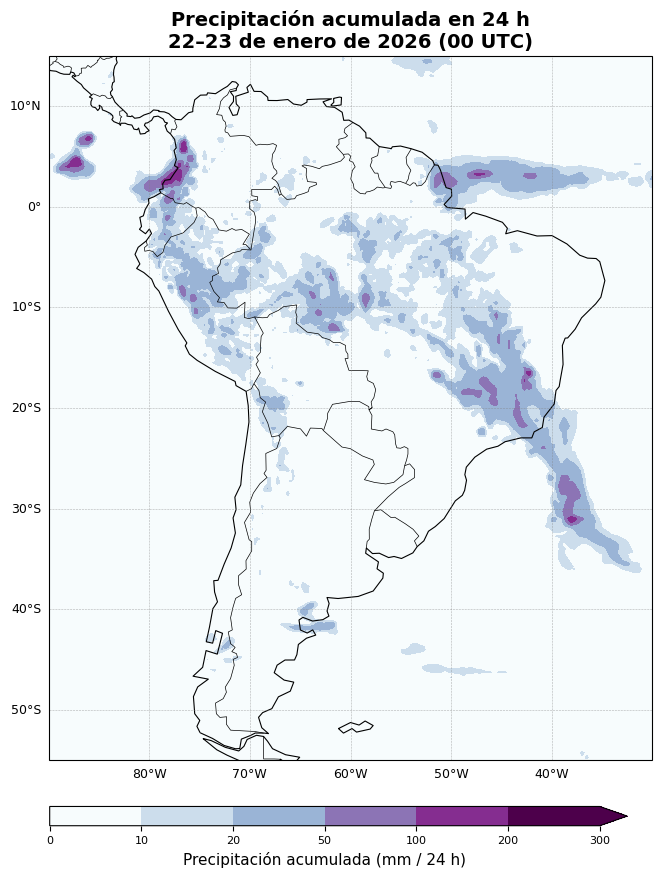

In [14]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
import matplotlib.ticker as mticker

# Abrir datos ERA5
ds = xr.open_dataset("PPacumulada22_23ene.nc")
tp = ds["tp"].sel(valid_time=slice("2026-01-22T00:00", "2026-01-23T00:00"))

# Acumulado 24 h (mm)
tp_acc = tp.sum(dim="valid_time") * 1000

# Configuración del mapa
fig = plt.figure(figsize=(14, 10))
proj = ccrs.PlateCarree()
ax = plt.axes(projection=proj)
ax.set_extent([-90, -30, 15, -55], crs=proj)

#Escala de colores (0-300mm)
levels = [0, 10, 20, 50, 100, 200, 300]
cmap = plt.cm.BuPu
norm = BoundaryNorm(levels, cmap.N)

# Ploteo
prec = ax.contourf(
    ds.longitude,
    ds.latitude,
    tp_acc,
    levels=levels,
    cmap=cmap,
    norm=norm,
    extend="max",
    transform=proj
)

# Elementos cartográficos
ax.add_feature(cfeature.LAND, facecolor="#f5f5f5")
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)

# Grillas 
gl = ax.gridlines(
    draw_labels=True,
    linewidth=0.4,
    color="gray",
    alpha=0.6,
    linestyle="--"
)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {"size": 9}
gl.ylabel_style = {"size": 9}
gl.xlocator = mticker.MultipleLocator(10)
gl.ylocator = mticker.MultipleLocator(10)

# Barra de colores 
cbar = plt.colorbar(
    prec,
    orientation="horizontal",
    pad=0.06,
    fraction=0.025,
    aspect=30
)
cbar.set_label("Precipitación acumulada (mm / 24 h)", fontsize=11)
cbar.ax.tick_params(labelsize=8)
cbar.set_ticks(levels)

# Títulos
plt.title(
    "Precipitación acumulada en 24 h\n"
    "22–23 de enero de 2026 (00 UTC)",
    fontsize=14,
    weight="bold"
)

# Guardar imagen
plt.savefig(
    "PPac22_23ene.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()


Presión a nivel del mar + HR (23-01-2026)

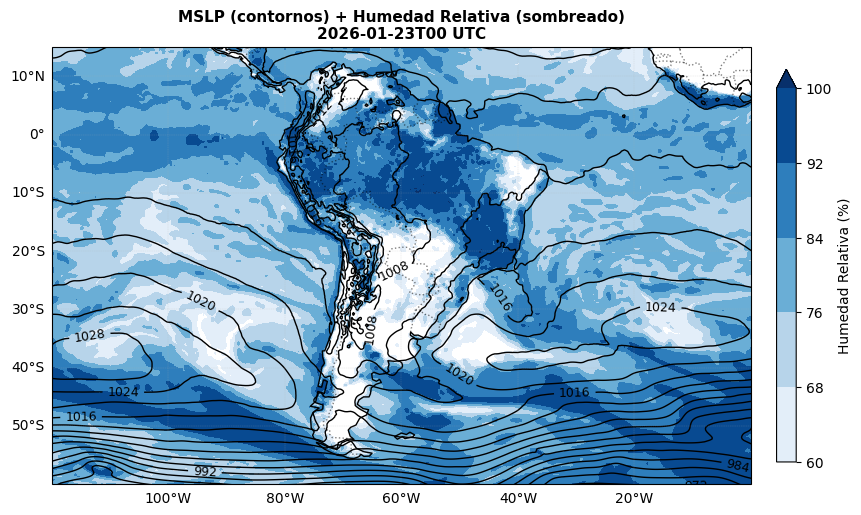

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

# Cargar datos ERA5
ds = xr.open_dataset("presion_humeda.nc")

# Presión al nivel del mar (Pa → hPa)
mslp = ds.msl / 100.0

# Temperatura y punto de rocío a 2 m (K → °C)
T2 = ds.t2m - 273.15
Td2 = ds.d2m - 273.15

# Calcular Humedad Relativa
def es(T):
    return 6.112 * np.exp((17.67 * T) / (T + 243.5))

RH = 100 * es(Td2) / es(T2)

# Fechas y parámetros
fechas_objetivo = ['2026-01-23T00:00:00']
intervalo = 4 

# Loop de ploteo
for fecha in fechas_objetivo:

    step_mslp = mslp.sel(valid_time=fecha, method='nearest')
    step_rh   = RH.sel(valid_time=fecha, method='nearest')

    # Cíclico en longitudes
    mslp_cyc, lon_cyc = add_cyclic_point(step_mslp.values, coord=step_mslp.longitude)
    rh_cyc,   lon_cyc_rh = add_cyclic_point(step_rh.values, coord=step_rh.longitude)

    fig, ax = plt.subplots(figsize=(11, 6), subplot_kw={'projection': ccrs.PlateCarree()})

    # Mapa base
    ax.set_extent([-120, 0, -60, 15], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=':', alpha=0.5)

    # Humedad Relativa (sombreado)
    rh_levels = np.arange(60, 101, 8)

    rh_plot = ax.contourf(
        lon_cyc_rh, step_rh.latitude, rh_cyc,
        levels=rh_levels,
        cmap="Blues",      
        transform=ccrs.PlateCarree(),
        extend="max"
    )

    cbar_rh = fig.colorbar(rh_plot, ax=ax, orientation="vertical", pad=0.03, shrink=0.85)
    cbar_rh.set_label("Humedad Relativa (%)", fontsize=10)

    # Contornos de MSLP (sin relleno)
    vmin, vmax = np.nanmin(step_mslp), np.nanmax(step_mslp)
    levels_cnt = np.arange(np.floor(vmin/intervalo)*intervalo, vmax + intervalo, intervalo)

    cs = ax.contour(
        lon_cyc, step_mslp.latitude, mslp_cyc,
        levels=levels_cnt,
        colors="black",
        linewidths=1.0,
        transform=ccrs.PlateCarree()
    )
    ax.clabel(cs, fmt="%d", fontsize=9, inline=True)

    #  Título y grillas
    fecha_str = np.datetime_as_string(step_mslp.valid_time.values, unit='h')
    ax.set_title(f"MSLP (contornos) + Humedad Relativa (sombreado)\n{fecha_str} UTC",
                 fontsize=11, fontweight="bold")

    gl = ax.gridlines(draw_labels=True, linewidth=0.3, linestyle="--", alpha=0.4)
    gl.top_labels = False
    gl.right_labels = False

    plt.show()


Divergencia + Convergencia + Vectores de viento (200hP)

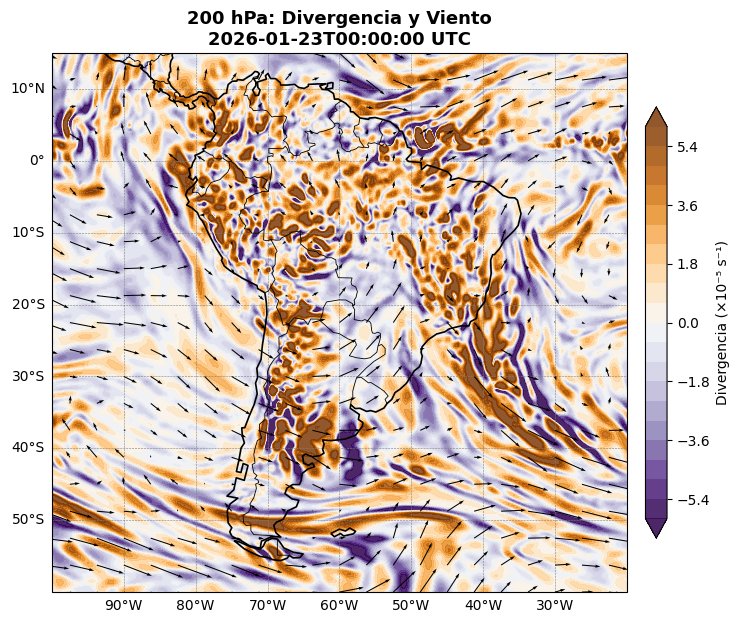

In [29]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

# 1. Cargar y limpiar datos
dg = xr.open_dataset("ERA2026_23ene_guia.nc")
if 'expver' in dg.dims:
    dg = dg.sel(expver=1).combine_first(dg.sel(expver=5))

# 2. Selección 200 hPa y fecha
fecha_query = '2026-01-23T00:00:00'
ds = dg.sel(pressure_level=200, valid_time=fecha_query, method='nearest')

# Variables
u = ds.u
v = ds.v
div = ds.d * 1e5   

# Punto cíclico
div_cyc, lon_cyc = add_cyclic_point(div.values, coord=ds.longitude)

#  Gráfica
fig, ax = plt.subplots(figsize=(12, 7), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-100, -20, -60, 15], crs=ccrs.PlateCarree())

# Divergencia sombreada 
levels_div = np.linspace(-6, 6, 21)

div_plot = ax.contourf(
    lon_cyc, ds.latitude, div_cyc,
    levels=levels_div,
    cmap="PuOr_r",
    extend="both",
    transform=ccrs.PlateCarree(),
    alpha=0.85
)

cbar = plt.colorbar(div_plot, ax=ax, pad=0.02, shrink=0.8)
cbar.set_label("Divergencia (×10⁻⁵ s⁻¹)", fontsize=10)

# Viento (vectores)
speed = np.sqrt(u**2 + v**2)
v_max = float(speed.max())

salto = 15
ax.quiver(
    ds.longitude[::salto].values, ds.latitude[::salto].values,
    u[::salto, ::salto].values, v[::salto, ::salto].values,
    transform=ccrs.PlateCarree(),
    scale=v_max * 10,
    width=0.0018,
    headwidth=3,
    color="black",
    zorder=4
)

# Geografía y grillas
ax.add_feature(cfeature.COASTLINE, linewidth=1.2, zorder=5)
ax.add_feature(cfeature.BORDERS, linewidth=0.6, zorder=5)

gl = ax.gridlines(draw_labels=True, linewidth=0.4, color='gray', linestyle='--')
gl.top_labels = gl.right_labels = False

# Título
ax.set_title(f"200 hPa: Divergencia y Viento\n{fecha_query} UTC",
             fontsize=13, fontweight='bold')

plt.show()


DIVERGENCIA + VECTORES DE VIENTO (200hPa)

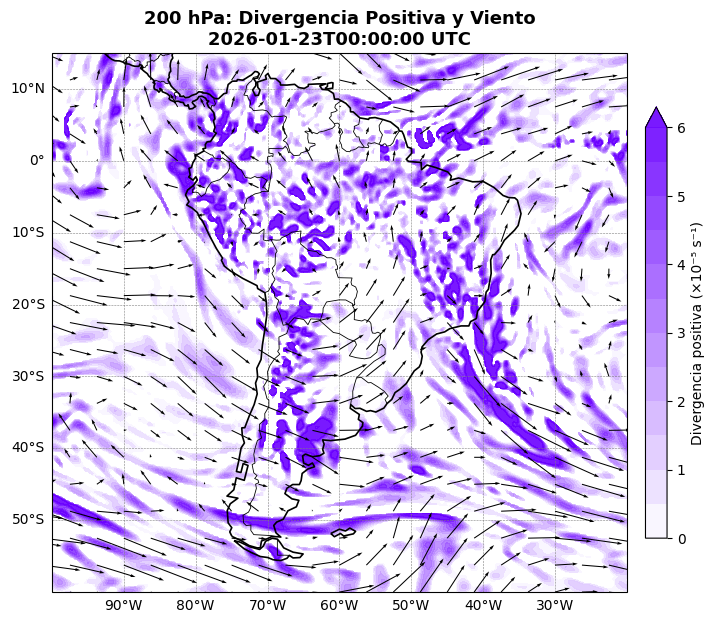

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from matplotlib.colors import LinearSegmentedColormap

# Cargar y limpiar datos
dg = xr.open_dataset("ERA2026_23ene.nc")
if 'expver' in dg.dims:
    dg = dg.sel(expver=1).combine_first(dg.sel(expver=5))


# Selección 200 hPa y fecha
fecha_query = '2026-01-23T00:00:00'
ds = dg.sel(pressure_level=200, valid_time=fecha_query, method='nearest')

# Variables
u = ds.u
v = ds.v
div = ds.d * 1e5  

# Solo divergencia positiva

div_pos = div.where(div > 0)

# Punto cíclico
div_cyc, lon_cyc = add_cyclic_point(div_pos.values, coord=ds.longitude)


# Paleta BLANCO/MORADO
colors = ["white", "#6a00ff"]
cmap_custom = LinearSegmentedColormap.from_list("blanco_morado", colors)

# Gráfica
fig, ax = plt.subplots(figsize=(12, 7), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-100, -20, -60, 15], crs=ccrs.PlateCarree())

# Escala meteorológica recomendada
vmax_div = 6
levels_div = np.linspace(0, vmax_div, 13)

# Divergencia sombreada
div_plot = ax.contourf(
    lon_cyc, ds.latitude, div_cyc,
    levels=levels_div,
    cmap=cmap_custom,
    extend="max",
    transform=ccrs.PlateCarree(),
    alpha=0.9
)

cbar = plt.colorbar(div_plot, ax=ax, pad=0.02, shrink=0.8)
cbar.set_label("Divergencia positiva (×10⁻⁵ s⁻¹)", fontsize=10)

# Viento (vectores)
speed = np.sqrt(u**2 + v**2)
v_max = float(speed.max())

salto = 15
ax.quiver(
    ds.longitude[::salto].values, ds.latitude[::salto].values,
    u[::salto, ::salto].values, v[::salto, ::salto].values,
    transform=ccrs.PlateCarree(),
    scale=v_max * 7,
    width=0.0018,
    headwidth=3,
    color="black",
    zorder=4
)

# Geografía y grillas
ax.add_feature(cfeature.COASTLINE, linewidth=1.2, zorder=5)
ax.add_feature(cfeature.BORDERS, linewidth=0.6, zorder=5)

gl = ax.gridlines(draw_labels=True, linewidth=0.4, color='gray', linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Título
ax.set_title(f"200 hPa: Divergencia Positiva y Viento\n{fecha_query} UTC",
             fontsize=13, fontweight='bold')

plt.show()
